# IMDB Subwords 8K With a Single Layer LSTM

In [12]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [13]:
# We will get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [14]:
# Extract the relevant fields
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_dataset:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s, l in test_dataset:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [15]:
# We will define some tokenizing constants
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [16]:
# We will work on tokenizing texts now

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [17]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_padded[1]))
print(training_sentences[1])

12 31 93 867 7 1256 6585 7961 421 365 2 26 14 9 988 1089 7 4 6728 6 276 5760 2587 2 81 6118 8029 2 139 1892 7961 5 5402 246 25 1 1771 350 5 369 56 5397 102 4 2547 3 4001 25 14 7822 209 12 3531 6585 7961 99 1 32 18 4762 3 19 184 3223 18 5855 1045 3 4232 3337 64 1347 5 1190 3 4459 8 614 7 3129 2 26 22 84 7020 6 71 18 4924 1160 161 50 2265 3 12 3983 2 12 264 31 2545 261 6 1 66 2 26 131 393 1 5846 6 15 5 473 56 614 7 1470 6
[  12   31   93  867    7 1256 6585 7961  421  365    2   26   14    9
  988 1089    7    4 6728    6  276 5760 2587    2   81 6118 8029    2
  139 1892 7961    5 5402  246   25    1 1771  350    5  369   56 5397
  102    4 2547    3 4001   25   14 7822  209   12 3531 6585 7961   99
    1   32   18 4762    3   19  184 3223   18 5855 1045    3 4232 3337
   64 1347    5 1190    3 4459    8  614    7 3129    2   26   22   84
 7020    6   71   18 4924 1160  161   50 2265    3   12 3983    2   12
  264   31 2545  261    6    1   66    2   26  131  393    1 5846    6
   15   

In [18]:
# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 173,825
Trainable params: 173,825
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/50
782/782 [==============================] - 25s 27ms/step - loss: 0.5654 - accuracy: 0.6830 - val_loss: 0.4556 - val_accuracy: 0.7838
Epoch 2/50
782/782 [==============================] - 21s 26ms/step - loss: 0.3582 - accuracy: 0.8449 - val_loss: 0.4673 - val_accuracy: 0.7816
Epoch 3/50
782/782 [==============================] - 21s 27ms/step - loss: 0.2740 - accuracy: 0.8866 - val_loss: 0.5029 - val_accuracy: 0.7795
Epoch 4/50
782/782 [==============================] - 21s 27ms/step - loss: 0.2060 - accuracy: 0.9182 - val_loss: 0.5944 - val_accuracy: 0.7565
Epoch 5/50
782/782 [==============================] - 21s 26ms/step - loss: 0.1433 - accuracy: 0.9454 - val_loss: 0.7281 - val_accuracy: 0.7679
Epoch 6/50
782/782 [==============================] - 21s 27ms/step - loss: 0.1000 - accuracy: 0.9624 - val_loss: 0.8618 - val_accuracy: 0.7504
Epoch 7/50
782/782 [==============================] - 21s 27ms/step - loss: 0.0637 - accuracy: 0.9760 - val_loss: 1.0852 - val_accuracy:

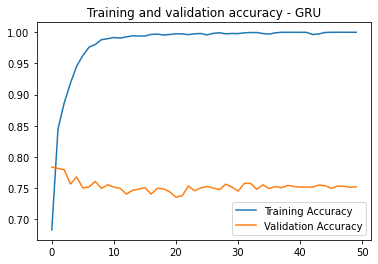

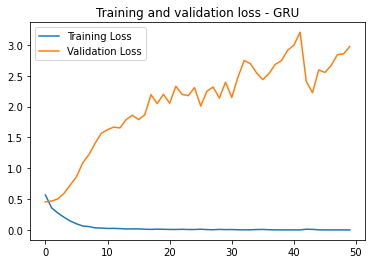

In [21]:
# Evaluate the training accuracy and losses

import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, label='Training Accuracy' )
plt.plot  ( epochs, val_acc, label='Validation Accuracy' )
plt.title ('Training and validation accuracy - GRU')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, label='Training Loss' )
plt.plot  ( epochs, val_loss, label='Validation Loss' )
plt.title ('Training and validation loss - GRU')
plt.legend()
plt.show()

In [22]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________
